# Classification Toko Baju using LSTM
## Importing libraries

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# Cek GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
# 1. Load Dataset
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv"
df = pd.read_csv(url)
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
# Ambil kolom penting
df = df[['Review Text', 'Recommended IND']].dropna()

In [ ]:
# Preprocessing teks
vectorizer = CountVectorizer(max_features=10000, stop_words='english')
X = vectorizer.fit_transform(df['Review Text']).toarray()
y = df['Recommended IND'].values

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Convert ke tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Buat dataset dan dataloader
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
import torch.optim as optim

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)  # [batch, seq_len=1, features]
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return self.sigmoid(out)

model = LSTMClassifier(input_dim=10000, hidden_dim=128, output_dim=1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
train_losses = []
train_accuracies = []

for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        probs = torch.sigmoid(outputs).squeeze()
        predicted = (probs > 0.5).long()

        loss = criterion(probs, labels.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)


    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {acc*100:.2f}%")


Epoch 1, Loss: 0.3825, Accuracy: 99.99%
Epoch 2, Loss: 0.3825, Accuracy: 99.99%
Epoch 3, Loss: 0.3825, Accuracy: 99.99%
Epoch 4, Loss: 0.3825, Accuracy: 99.99%
Epoch 5, Loss: 0.3825, Accuracy: 99.99%
Epoch 6, Loss: 0.3824, Accuracy: 99.99%
Epoch 7, Loss: 0.3824, Accuracy: 99.99%
Epoch 8, Loss: 0.3824, Accuracy: 99.99%
Epoch 9, Loss: 0.3824, Accuracy: 99.99%
Epoch 10, Loss: 0.3824, Accuracy: 99.99%


In [ ]:
def evaluate(model, loader, y_true):
    model.eval()
    y_preds, y_probs = [], []

    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            probs = outputs.cpu().numpy()
            preds = (outputs > 0.5).int().cpu().numpy()
            y_probs.extend(probs)
            y_preds.extend(preds)

    acc = accuracy_score(y_true, y_preds)
    prec = precision_score(y_true, y_preds)
    rec = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    f1_sq = f1**2
    auc = roc_auc_score(y_true, y_probs)
    loss = log_loss(y_true, y_probs)

    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F1 Squared: {f1_sq:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Loss: {loss:.4f}\n")

print("\n🔍 Final Results:")
print("Training Set Metrics:")
evaluate(model, train_loader, y_train.numpy())

print("Test Set Metrics:")
evaluate(model, test_loader, y_test.numpy())

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model_with_accuracy(model, train_loader, test_loader):
    model.eval()
    y_true_train, y_pred_train, y_probs_train = [], [], []
    y_true_test, y_pred_test, y_probs_test = [], [], []

    with torch.no_grad():
        # Evaluasi pada data training
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).squeeze()
            predicted = (probs > 0.5).long()

            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())
            y_probs_train.extend(probs.cpu().numpy())

        # Evaluasi pada data testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).squeeze()
            predicted = (probs > 0.5).long()

            y_true_test.extend(labels.cpu().numpy())
            y_pred_test.extend(predicted.cpu().numpy())
            y_probs_test.extend(probs.cpu().numpy())

    # Hitung metrik untuk data training
    train_accuracy = accuracy_score(y_true_train, y_pred_train)
    train_precision = precision_score(y_true_train, y_pred_train)
    train_recall = recall_score(y_true_train, y_pred_train)
    train_f1 = f1_score(y_true_train, y_pred_train)
    train_auc = roc_auc_score(y_true_train, y_probs_train)

    # Hitung metrik untuk data testing
    test_accuracy = accuracy_score(y_true_test, y_pred_test)
    test_precision = precision_score(y_true_test, y_pred_test)
    test_recall = recall_score(y_true_test, y_pred_test)
    test_f1 = f1_score(y_true_test, y_pred_test)
    test_auc = roc_auc_score(y_true_test, y_probs_test)

    # Cetak hasil dalam bentuk persen
    print("=== Hasil Evaluasi Training ===")
    print(f"Akurasi      : {train_accuracy * 100:.2f}%")
    print(f"Presisi      : {train_precision * 100:.2f}%")
    print(f"Recall       : {train_recall * 100:.2f}%")
    print(f"F1 Score     : {train_f1 * 100:.2f}%")
    print(f"AUC          : {train_auc * 100:.2f}%\n")

    print("=== Hasil Evaluasi Testing ===")
    print(f"Akurasi      : {test_accuracy * 100:.2f}%")
    print(f"Presisi      : {test_precision * 100:.2f}%")
    print(f"Recall       : {test_recall * 100:.2f}%")
    print(f"F1 Score     : {test_f1 * 100:.2f}%")
    print(f"AUC          : {test_auc * 100:.2f}%")

    return {
        'True Labels': y_true_test,
        'Probs': y_probs_test
    }


In [ ]:
results = evaluate_model_with_accuracy(model, train_loader, test_loader)

=== Hasil Evaluasi Training ===
Akurasi      : 84.69%
Presisi      : 84.24%
Recall       : 100.00%
F1 Score     : 91.45%
AUC          : 100.00%

=== Hasil Evaluasi Testing ===
Akurasi      : 83.46%
Presisi      : 83.38%
Recall       : 99.73%
F1 Score     : 90.82%
AUC          : 87.35%


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


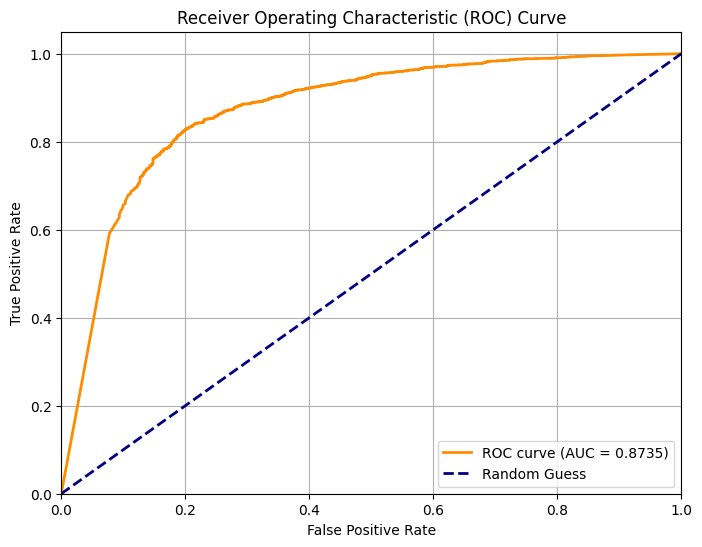

In [ ]:
plot_roc_curve(results['True Labels'], results['Probs'])

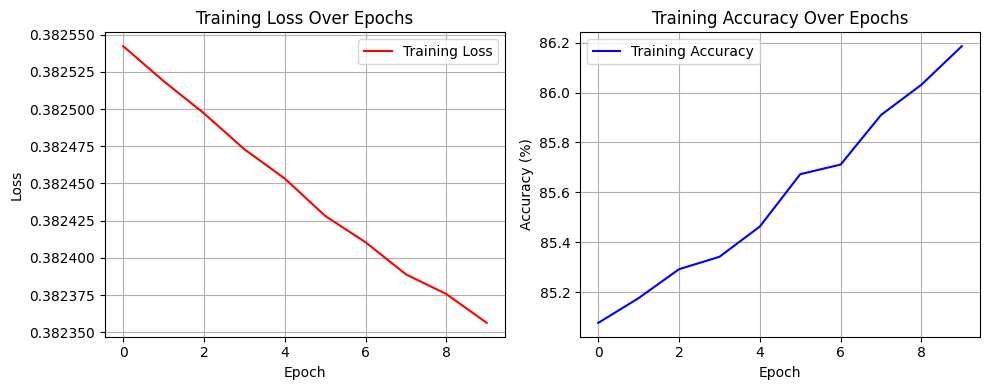

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='red')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot([acc * 100 for acc in train_accuracies], label='Training Accuracy', color='blue')
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


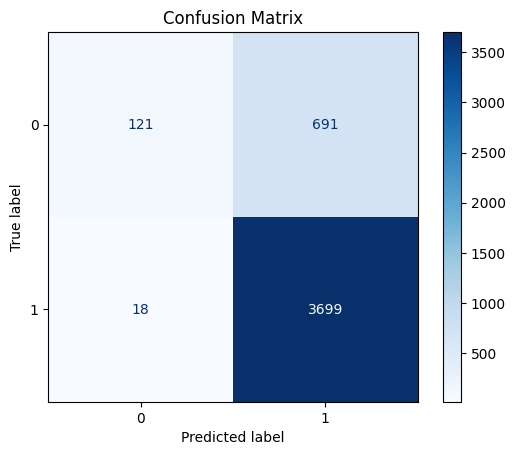

Classification Report:

              precision    recall  f1-score   support

         0.0       0.87      0.15      0.25       812
         1.0       0.84      1.00      0.91      3717

    accuracy                           0.84      4529
   macro avg       0.86      0.57      0.58      4529
weighted avg       0.85      0.84      0.79      4529



In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import seaborn as sns
# Evaluasi pada data testing
model.eval()
y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        probs = torch.sigmoid(outputs).squeeze()
        predicted = (probs > 0.5).long()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred))



# Penjelasan Persamaan Matematika pada Model LSTM

Model **LSTM (Long Short-Term Memory)** merupakan jenis RNN (Recurrent Neural Network) yang dirancang untuk mengatasi masalah long-term dependencies dalam data deret waktu. LSTM menggunakan struktur "gates" (gerbang) untuk mengontrol aliran informasi.

Berikut adalah persamaan-persamaan utama dalam LSTM beserta penjelasannya:

### 1. Forget Gate

$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$

**Penjelasan:**

- Menentukan informasi mana dari cell state sebelumnya yang akan "dilupakan".
- \( \sigma \): Fungsi aktivasi sigmoid, menghasilkan nilai antara 0 dan 1.
- \( W_f \): Matriks bobot forget gate.
- \( h_{t-1} \): Hidden state dari waktu sebelumnya.
- \( x_t \): Input saat ini.
- \( b_f \): Bias forget gate.

### 2. Input Gate

$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$

$$
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$

**Penjelasan:**

- \( i_t \): Menentukan seberapa besar informasi baru akan ditambahkan ke cell state.
- \( \tilde{C}_t \): Kandidat nilai baru untuk sel memori, hasil dari fungsi aktivasi tanh.
- \( W_i, W_C \): Bobot untuk input dan kandidat memori.
- \( b_i, b_C \): Bias masing-masing.
- \( \tanh \): Fungsi aktivasi tanh, menghasilkan nilai antara -1 dan 1.

### 3. Cell State Update

$$
C_t = f_t * C_{t-1} + i_t * \tilde{C}_t
$$

**Penjelasan:**

- Cell state saat ini diperbarui dengan kombinasi dari:
  - Bagian dari cell state lama yang masih relevan (dengan \( f_t \)).
  - Informasi baru yang penting (dengan \( i_t \cdot \tilde{C}_t \)).
- \( * \): Perkalian elemen per elemen (Hadamard Product).


###  4. Output Gate dan Hidden State

$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$

$$
h_t = o_t * \tanh(C_t)
$$

**Penjelasan:**

- \( o_t \): Output gate, menentukan bagian mana dari cell state yang akan menjadi output.
- \( h_t \): Hidden state (output aktual) dari LSTM pada waktu t.
- Fungsi tanh digunakan untuk menskalakan cell state ke rentang -1 sampai 1.

## Kesimpulan

Setiap gate dalam LSTM memainkan peran penting untuk mempertahankan informasi yang relevan dan membuang informasi yang tidak diperlukan. Mekanisme ini membantu model LSTM untuk belajar dari urutan data yang panjang secara lebih stabil dibandingkan RNN standar.

---
